In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time

from scipy import stats

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import category_encoders as ce



# for classification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# for regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Preprocessing of the data

In [2]:
# load and import the data

df_final = pd.read_csv('df_model.csv')

In [3]:
df_model = df_final.copy()

In [4]:
def drop_columns(df):
    '''
    Drop columns from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to drop columns from

        
    Returns
    -------
    df : pandas dataframe
        The dataframe with the columns dropped
    '''
    
    #'ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE'

    cols_to_drop = ['RFM_BUYER', 'ORDER_VALUE_RANGE','ID_CONDITION', 'ORDER_MARKETING_CHANNEL' , 
                   'Total_likes', 'Total_wishes', 'Total_MMAO_NB', 'Avg_commision_x' , 'Avg_commision_y', 
                   'NL_REACTIVITY_GROUP','NB_PURCHASED', 'RANK_BUYER', 'BUYER_SEGMENT', 'NB_SOLD','RANK_WITHIN_SEGMENT', 
                   'ID_SEGMENT', 'ID_RFM_BUYER','Frequnecy_like_12M']
    
    #
    #'NB_products_liked'

    to_drop_maybe = ['NB_products_liked','NB_categories_liked', 'NB_products_commented', 'NB_categories_commented']

    df.drop(cols_to_drop, axis=1, inplace=True)

    return df

In [5]:
def date_time_converting(df):
    '''
    Convert the date columns to datetime and create new columns for the number of days 
    between the first order and the creation of the account

    Parameters
    ----------

    df : pandas dataframe
    The dataframe to convert the date columns to datetime and create new columns for the 
    number of days between the first order and the creation of the account

    Returns
    -------
    df : pandas dataframe
    The dataframe with the date columns converted to datetime and new columns for the

    '''
    # Convert the date columns to datetime
    df['DATE_CREATION'] = pd.to_datetime(df['DATE_CREATION'])
    df['DATE_FIRST_PURCHASE'] = pd.to_datetime(df['DATE_FIRST_PURCHASE'])
    df['DATE_LAST_LOGIN'] = pd.to_datetime(df['DATE_LAST_LOGIN'])
    df['DATE_LAST_PURCHASE'] = pd.to_datetime(df['DATE_LAST_PURCHASE'])

    # Create a new column for the number of days between the first order and the creation of the account
    df['days_bf_first_order'] = (df['DATE_FIRST_PURCHASE'] - df['DATE_CREATION']).dt.days

    # recency login compared to today
    df['days_since_last_login'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_LOGIN']).dt.days

    # recency order compared to today
    #df['days_since_last_order'] = (pd.to_datetime('2023/02/11') - df['DATE_LAST_PURCHASE']).dt.days

    # Drop the date columns
    df.drop(['DATE_CREATION', 'DATE_NEW_BUYER', 'LastLikeDate', 'LastCommentDate', 
             'DATE_FIRST_PURCHASE', 'DATE_LAST_LOGIN', 'DATE_LAST_PURCHASE'], axis=1, inplace=True)
    df.drop(['Total_nb_likes', 'Total_nb_wish'], axis=1, inplace=True)

    return df

In [6]:
def missing_values(df):
    # Dealing with the missing values

    # Replacing the missing values with 0 
    df['NB_products_liked'].fillna(0, inplace=True)
    df['NB_categories_liked'].fillna(0, inplace=True)
    #df['Frequnecy_like_12M'].fillna(0, inplace=True)
    df['NB_products_commented'].fillna(0, inplace=True)
    df['NB_categories_commented'].fillna(0, inplace=True)
    df['Frequnecy_comment_12M'].fillna(0, inplace=True)

    # Replacing the missing values with 999
    df['Recency_comment'].fillna(999, inplace=True)
    df['Recency_liked'].fillna(999, inplace=True)

    return df

In [7]:
import category_encoders as ce

cols_to_encode = ['ID_CATEGORY', 'ID_SUBCATEGORY', 'ID_BRAND', 'ID_PAYMENT_TYPE']

def target_encoding(train_df, valid_df, cols_to_encode, target_col):
    """
    Apply target encoding to a set of columns and avoid data leakage.
    
    Args:
        train_df (pandas.DataFrame): The training data.
        valid_df (pandas.DataFrame): The validation/test data.
        cols_to_encode (list of str): The names of the columns to encode.
        target_col (str): The name of the target column.
    
    Returns:
        pandas.DataFrame: The training data with target-encoded columns,
                           and the validation/test data with corresponding target-encoded columns.
    """
    # Create a TargetEncoder object
    te = ce.TargetEncoder()
    
    # Fit the target encoder on the training data
    te.fit(train_df[cols_to_encode], target_col)
    
    # Transform the training and validation/test data separately
    train_encoded = te.transform(train_df[cols_to_encode])
    valid_encoded = te.transform(valid_df[cols_to_encode])
    
    # Replace the original columns with the encoded columns in the training and validation/test data
    train_df = train_df.drop(cols_to_encode, axis=1)
    train_df = pd.concat([train_df, train_encoded], axis=1)
    
    valid_df = valid_df.drop(cols_to_encode, axis=1)
    valid_df = pd.concat([valid_df, valid_encoded], axis=1)
    
    return train_df, valid_df

def encoding(df):
    ### ecoding the categorical variables 
    
    ##ordinal encoding
    # USER_SEGMENT
    user_seg_map = {'Hibernating' :0, 'Inactive 6-12M': 1, 'Dormant 6M': 2, 'About to Sleep': 3, 'At High Risk':4, 'At Risk' :5, 'Need Attention':6, 'New Customer': 7, 'Potential Engaged':8, 'Engaged':9, 'Highly Engaged':10}
    df['USER_SEGMENT'] = df['USER_SEGMENT'].map(user_seg_map)


    # if task == 'classification':
    #     class_te(df)
    # elif task == 'regression':
    #     regr_te(df)
    # else: 
    #     print('Target encoding was not choosed for this run')
    # #BUYER_SEGMENT 
    # buyer_seg_map = {'Low potential one timers':0,'High potential one timers' : 1,'Low quality repeaters':2, 'High potential repeaters':3, 'Top buyers - only':4, 'Top buyers - low value': 5, 'Top buyers - high value':6, 'Top buyers - VVIC':7}
    # # OR maybe map with levels 1 to 3 with one timers, repeaters and top buyers
    # df['BUYER_SEGMENT'] = df['BUYER_SEGMENT'].map(buyer_seg_map)
    #drop the columns 

    return df

In [8]:
df = drop_columns(df_model)
df = date_time_converting(df_model)
df = missing_values(df_model)
df = encoding(df_model)

# set ID_BUYER as index

df.set_index('ID_BUYER', inplace=True)

In [9]:
def outliers_removal(df, outlier_method:str=None):
    '''
    Remove the outliers from the dataframe

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to remove the outliers from

    outlier_method : str
        The method to use to remove the outliers

    Returns
    -------
    df : pandas dataframe
        The dataframe with the outliers removed
    '''

    if outlier_method == 'IQR':
        # IQR method
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

    elif outlier_method == 'zscore':
        # Z-score method
        df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

    return df

In [10]:
def select_features(X_train, y_train, X_test, method:str=None, VT_threshold=0.1, KBest_k=10):

    colname = X_train.columns

    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()

    if method == 'variance':
        # create an instance of VarianceThreshold with a threshold of 0.1
        selector = VarianceThreshold(threshold=VT_threshold)

        # fit the selector to the training data
        selector.fit(X_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = selector.get_support() 


        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'univariate':
        # create an instance of SelectKBest with the desired parameters
        selector = SelectKBest(f_regression, k=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    elif method == 'recursive':
        # create an instance of SelectKBest with the desired parameters
        selector = RFE(estimator=LinearRegression(), n_features_to_select=10)

        # fit the selector to the training data
        selector.fit(X_train, y_train)

        # transform the training and test data using the selector
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)

        # get the columns that were selected
        selected_columns = colname[selector.get_support()]

        # print the columns that were not selected

        print('Columns with low variance: ', set(colname) - set(selected_columns))
        
        return X_train, X_test, selected_columns

    else:
        print('Invalid method')

In [9]:
def corr_plot(df):
    '''
    Plot correlation matrix

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to plot

    Returns
    -------
    plot of correlation matrix
    
    '''

    corr = df.corr()
    f, ax = plt.subplots(figsize=(20, 9))
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask= np.triu(corr, k=1))
    plt.show()

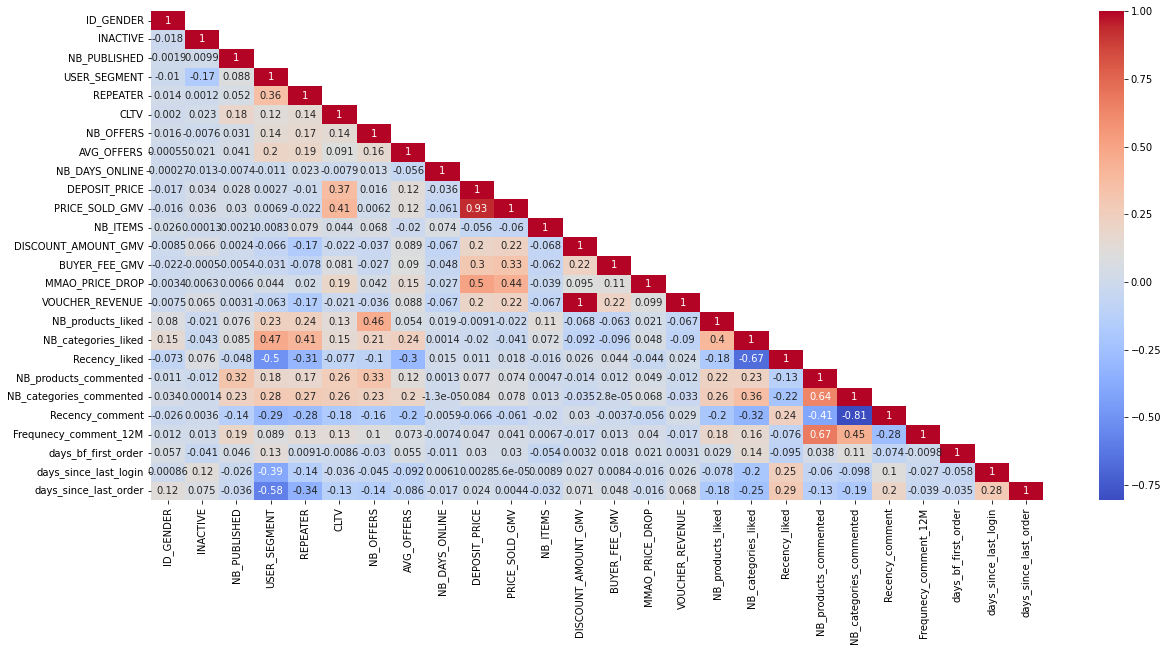

In [10]:
corr_plot(df)

In [10]:
# keep only 10000 rows for the moment 
df_REPEATER_sample = df.sample(n=10000, random_state=42)

df_CLTV_sample = df.sample(n=10000, random_state=42)

In [11]:
df_REPEATER_sample = df.copy()

# Split the data into X and y 
X_REPEATER = df_REPEATER_sample.drop(['REPEATER', 'CLTV'], axis=1)
y_REPEATER = df_REPEATER_sample['REPEATER']

# Split the data into train and test
X_train_REPEATER, X_test_REPEATER, y_train_REPEATER, y_test_REPEATER = train_test_split(X_REPEATER, y_REPEATER, test_size=0.2, random_state=42)

# Apply Target Encoding
X_train_REPEATER, X_test_REPEATER = target_encoding(X_train_REPEATER, X_test_REPEATER, cols_to_encode, target_col=y_train_REPEATER)


In [13]:
df_CLTV_sample = df.copy()

# Split the data into X and y
X_CLTV = df_CLTV_sample.drop(['REPEATER', 'CLTV'], axis=1)
y_CLTV = df_CLTV_sample['CLTV']

# Split the data into train and test
X_train_CLTV, X_test_CLTV, y_train_CLTV, y_test_CLTV = train_test_split(X_CLTV, y_CLTV, test_size=0.2, random_state=42)

# Apply Target Encoding
X_train_CLTV, X_test_CLTV = target_encoding(X_train_CLTV, X_test_CLTV, cols_to_encode, target_col=y_train_CLTV)

In [15]:
# keeping colnames for later use

colnames = X_REPEATER.columns

In [16]:
def pre_processing(df, X_train, X_test, scaling:bool = False, scaler:str = None, outliers:bool = False, outliers_method:str = None):
    '''
    Preprocess the data to be used in the model

    Parameters
    ----------
    df : pandas dataframe
        The dataframe to preprocess

    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    Returns
    -------
    X_train : pandas dataframe
        The train set after preprocessing

    X_test : pandas dataframe
        The test set after preprocessing

    '''

    # Scaling the data
    if scaling:
        if scaler == 'MinMaxScaler':
            # MinMaxScaler
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        elif scaler == 'StandardScaler':
            # StandardScaler
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        else:
            print('Please choose a valid scaler')   
    
    return X_train, X_test

# Model 1 : Predicting the probability of a customer to be a Repeater

In [17]:
X_train_REPEATER_scaled, X_test_REPEATER_scaled = pre_processing(df_REPEATER_sample, X_train_REPEATER, X_test_REPEATER, scaling=True, scaler='MinMaxScaler')

Testing different classification models

In [18]:
def classification_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the classification model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_classification_result where each row represents the result of one model
    The columns should be the name of the model, the accuracy score, the precision score, the recall score and the f1 score

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Logistic Regression': LogisticRegression(), 'KNN': KNeighborsClassifier(), #'SVM': SVC(), 
              'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier( n_jobs=-1),
              'Gradient Boosting': GradientBoostingClassifier(), 'XGBoost': XGBClassifier(verbosity=0, n_jobs=-1, tree_method='gpu_hist', gpu_id=0, random_state=42, objective='binary:logistic'),
                'LightGBM': LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42),
                'CatBoost': CatBoostClassifier(verbose=0, random_state=42, task_type='GPU')}
    
    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    for name, model in models.items():
        start = time.time()

        # Perform 5-fold cross validation

        cv = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)

        # Get the mean of the scores

        accuracy = cv['test_accuracy'].mean()
        precision = cv['test_precision'].mean()
        recall = cv['test_recall'].mean()
        f1 = cv['test_f1'].mean()

        # Append the scores to the df_classification_result dataframe

        df_classification_result = df_classification_result.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')

    
    print('Finished fitting and evaluating all the models')

    df_classification_result = df_classification_result.sort_values(by='F1', ascending=False)

    return df_classification_result      

In [19]:
df_classification_result = classification_model_testing(df_REPEATER_sample, X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER)

Logistic Regression has been fitted and evaluated
It took 3.8513355255126953 seconds to fit and evaluate the model
--------------------------------------
KNN has been fitted and evaluated
It took 33.12091255187988 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 5.539182186126709 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 20.054536819458008 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 111.61293935775757 seconds to fit and evaluate the model
--------------------------------------
XGBoost has been fitted and evaluated
It took 3.1774561405181885 seconds to fit and evaluate the model
--------------------------------------
LightGBM has been fitted and evaluated
It took 2.7024881839752197 seconds to fit and evaluate the model
----------------

In [18]:
df_classification_result # with the subset of 10k rows

,Model,Accuracy,Precision,Recall,F1
7,CatBoost,0.819875,0.800711,0.823971,0.812000
6,LightGBM,0.810250,0.788299,0.817885,0.802745
4,Gradient Boosting,0.811500,0.799177,0.802795,0.800797
5,XGBoost,0.799625,0.782393,0.798033,0.789887
3,Random Forest,0.787875,0.778939,0.769448,0.774016
0,Logistic Regression,0.761875,0.746266,0.751976,0.748832
1,KNN,0.744875,0.720630,0.751448,0.735480
2,Decision Tree,0.736625,0.721894,0.720749,0.721096


In [21]:
df_classification_result # with whole dataset

,Model,Accuracy,Precision,Recall,F1
6,LightGBM,0.820385,0.778866,0.854392,0.814871
7,CatBoost,0.821162,0.782540,0.849554,0.814663
5,XGBoost,0.812984,0.773153,0.843211,0.806658
4,Gradient Boosting,0.813135,0.786434,0.818367,0.802076
1,KNN,0.773941,0.741883,0.784296,0.762494
0,Logistic Regression,0.770902,0.759974,0.737891,0.748766
2,Decision Tree,0.736788,0.714510,0.717985,0.716243
3,Random Forest,0.732821,0.714084,0.704673,0.709344


Choice of best models, and hyperparameter tuning

In [19]:
# function for hyper parameter tuning LightGBM 
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMClassifier(boosting_type='gbdt', objective='binary', n_jobs=-1, random_state=42)

    start = time.time()

    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'It took {end-start} seconds or {(end-start) / 60} minutes to fit and evaluate the model')

    print('--------------------------------------')
    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    print('--------------------------------------')

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    # Evaluate the model

    accuracy = accuracy_score(y_test, y_pred)

    print(f'Accuracy score: {accuracy}')

    precision = precision_score(y_test, y_pred)

    print(f'Precision score: {precision}')

    recall = recall_score(y_test, y_pred)

    print(f'Recall score: {recall}')

    f1 = f1_score(y_test, y_pred)

    print(f'F1 score: {f1}')
    print('--------------------------------------')

    # put results in a dataframe

    df_classification_result = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

    df_classification_result = df_classification_result.append({'Model': 'LightGBM_tuned', 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}, ignore_index=True)

    # Create a confusion matrix

    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))

    # Create a classification report

    print('Classification report: \n', classification_report(y_test, y_pred))

    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()

    return bayes_cv_tuner.best_estimator_, df_classification_result

It took 318.1156735420227 seconds or 5.301927892367045 minutes to fit and evaluate the model
--------------------------------------
Best score:  0.82125
Best params:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_depth', 7), ('min_child_samples', 92), ('n_estimators', 653), ('num_leaves', 59), ('reg_alpha', 0.24780876747613212), ('reg_lambda', 0.0), ('subsample', 0.7336559844582153)])
--------------------------------------
Accuracy score: 0.7865
Precision score: 0.764102564102564
Recall score: 0.7908704883227177
F1 score: 0.7772561293688053
--------------------------------------
Confusion matrix:  [[828 230]
 [197 745]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.80      1058
         1.0       0.76      0.79      0.78       942

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2

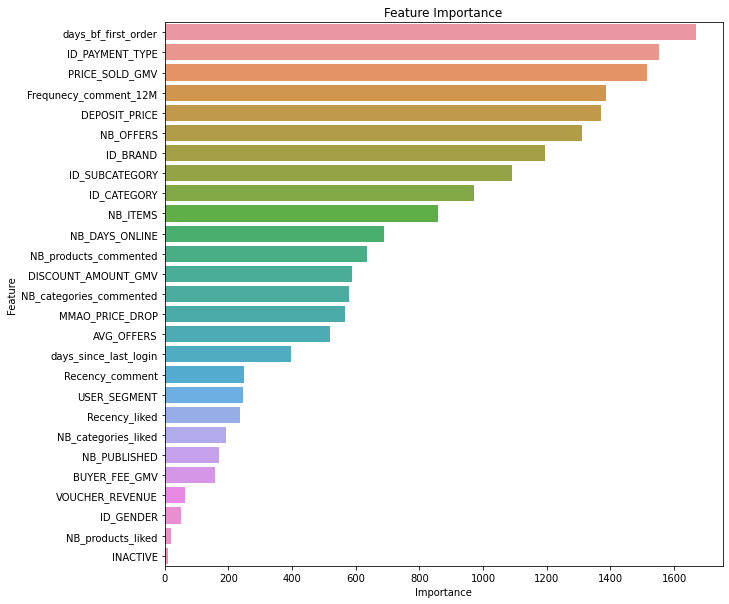

In [20]:
best_model_LGBM_class, df_classification_result = hyperparameter_tuning_lgbm(X_train_REPEATER_scaled, X_test_REPEATER_scaled, y_train_REPEATER, y_test_REPEATER)

# Model 2 : Predicting the Customer Lifetime Value (CLV) of a customer 

In [22]:
X_train_CLTV_scaled, X_test_CLTV_scaled = pre_processing(df, X_train_CLTV, X_test_CLTV, scaling=True, scaler='MinMaxScaler')

In [24]:
def regression_model_testing(df, X_train, X_test, y_train, y_test):
    '''

    Function that testes all the regression model imported into the notebook to have a global idea of the best model to use
    It should output a pandas dataframe called df_regression_result where each row represents the result of one model
    The columns should be the name of the model, the mean absolute error, the mean squared error and the root mean squared error

    Parameters
    ----------
    df : pandas dataframe
    The dataframe to use to train the model

    '''
    #set a seed for reproducibility
    np.random.seed(42)

    # Import the models

    models = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(),
                'ElasticNet Regression': ElasticNet(), 'Decision Tree': DecisionTreeRegressor(), 'Random Forest': RandomForestRegressor( n_jobs=-1),
                'Gradient Boosting': GradientBoostingRegressor(), 'CatBoost': CatBoostRegressor(verbose=0), 
                'XGBoost': XGBRegressor(n_jobs=-1, random_state=42, verbosity=0, objective='reg:squarederror', booster='gbtree', tree_method='gpu_hist'),
                'LightGBM': LGBMRegressor(n_jobs=-1, random_state=42, boosting_type='gbdt', objective='regression'),}
    
    df_regression_result = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        df_regression_result = df_regression_result.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, ignore_index=True)
        end = time.time()
        print(f'{name} has been fitted and evaluated')
        print(f'It took {end-start} seconds to fit and evaluate the model')
        print('--------------------------------------')


    print('Finished fitting and evaluating all the models')
    
    df_regression_result = df_regression_result.sort_values(by='R2', ascending=False)

    return df_regression_result
        

In [25]:
df_regression_result = regression_model_testing(df, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

Linear Regression has been fitted and evaluated
It took 0.17057442665100098 seconds to fit and evaluate the model
--------------------------------------
Ridge Regression has been fitted and evaluated
It took 0.0358731746673584 seconds to fit and evaluate the model
--------------------------------------
Lasso Regression has been fitted and evaluated
It took 0.5956363677978516 seconds to fit and evaluate the model
--------------------------------------
ElasticNet Regression has been fitted and evaluated
It took 0.0458831787109375 seconds to fit and evaluate the model
--------------------------------------
Decision Tree has been fitted and evaluated
It took 1.7822265625 seconds to fit and evaluate the model
--------------------------------------
Random Forest has been fitted and evaluated
It took 22.484506607055664 seconds to fit and evaluate the model
--------------------------------------
Gradient Boosting has been fitted and evaluated
It took 23.752952814102173 seconds to fit and evalu

In [26]:
df_regression_result # with whole dataset

,Model,MAE,MSE,RMSE,R2
7,CatBoost,398.410215,1.032647e+06,1016.192508,0.996982
8,XGBoost,362.918831,1.323120e+06,1150.269387,0.996134
5,Random Forest,141.183467,1.369425e+06,1170.224385,0.995998
9,LightGBM,513.009730,1.684276e+06,1297.796591,0.995078
4,Decision Tree,117.574250,2.288183e+06,1512.674177,0.993314
6,Gradient Boosting,979.093036,5.180002e+06,2275.961839,0.984863
0,Linear Regression,4150.498663,2.342153e+08,15304.093705,0.315589
2,Lasso Regression,4125.146472,2.344593e+08,15312.064253,0.314875
1,Ridge Regression,4129.048987,2.349818e+08,15329.116354,0.313349
3,ElasticNet Regression,3871.030253,3.354899e+08,18316.382689,0.019649


In [21]:
df_regression_result # with subset of 10k rows

,Model,MAE,MSE,RMSE,R2
8,XGBoost,627.922185,1.294942e+07,3598.530626,0.971269
4,Decision Tree,717.075120,1.453283e+07,3812.194952,0.967756
7,CatBoost,698.370406,1.549438e+07,3936.290405,0.965622
5,Random Forest,706.379700,2.516912e+07,5016.883495,0.944157
9,LightGBM,1021.072959,3.378199e+07,5812.228055,0.925047
6,Gradient Boosting,1238.775653,4.268169e+07,6533.122408,0.905301
2,Lasso Regression,4408.627432,2.844824e+08,16866.605679,0.368813
0,Linear Regression,4409.702930,2.844897e+08,16866.822240,0.368797
1,Ridge Regression,4409.573905,2.844897e+08,16866.822786,0.368797
3,ElasticNet Regression,4326.285650,2.861177e+08,16915.014349,0.365185


In [45]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def xgb_evaluation(df, X_train, X_test, y_train, y_test):
    '''
    df : dataframe qui contient les données à analyser

    outliers: booléen qui permet de supprimer les outliers ou non
    -> outliers = True : on supprime les outliers
    -> outliers = False : on ne supprime pas les outliers
    
    Fonction qui permet d'effectuer une Grid Search sur les hyperparamètres du modèle XGBoost
    Ensuite, on évalue le modèle avec les meilleurs hyperparamètres

    return: y_pred : les prédictions du modèle, model : le modèle avec les meilleurs hyperparamètres

    '''
    # Grid Search
    # choix des hyperparamètres à tester pour le modèle XGBoost
    param_grid = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(2, 10),
    'subsample': Real(0.1, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'reg_lambda': Real(1e-9, 1000, prior='log-uniform'),
    'reg_alpha': Real(1e-9, 1.0, prior='log-uniform'),
    'gamma': Real(1e-9, 0.5, prior='log-uniform'),
    'min_child_weight': Integer(1, 10)}


    # cross validation avec 5 folds et mélange des données à chaque itération
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # création du modèle
    xgb_model = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42)

    start = time.time() # début du chronomètre
    
    bayes_cv_tuner = BayesSearchCV(
        xgb_model,
        param_grid,
        n_iter=100,
        cv=cv,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    # fit the model with the training data
    bayes_cv_tuner.fit(X_train, y_train)

    # print the best parameters and score
    print(bayes_cv_tuner.best_params_)
    print(bayes_cv_tuner.best_score_)

    # Evaluation du modèle avec les meilleurs hyperparamètres
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest = xgb.DMatrix(X_test, label=y_test)

    # create a new model with the best parameters
    gbr = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, tree_method='gpu_hist', random_state=42, **bayes_cv_tuner.best_params_)

    # train the model
    model_test = xgb.train(gbr.get_xgb_params(), xgtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(xgtest, 'test')], verbose_eval=False)

    # make predictions with the trained model
    y_pred = model_test.predict(xgtest)

    end= time.time() # fin du chronomètre

    print(f'It took {end-start} seconds to tune, fit and evaluate the model')

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    print('---------')

    print(f'MSE = {MSE}')
    print(f'RMSE = {RMSE}')
    print(f'MAE = {MAE}')
    print(f'R2 = {R2}')

    print('---------')

    # create a dataframe with the model and scores 

    df_model = pd.DataFrame({'Model': ['XGBoost_Tuned'], 'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]})


    print('Evaluation finie !')

    print('---------')

    # plot feature importance pour le modèle XGBoost

    feature_importance = model_test.get_score(importance_type='total_gain')
    feature_importance = list(feature_importance.values())
    sorted_feature_importance = sorted(feature_importance, reverse=False)
    
    plt.figure(figsize=(10, 10))
    sns.barplot(x=sorted_feature_importance, y=colnames, orient='h')
    plt.title('XGBoost Feature importance')
    plt.show()


    print('---------')

    # plot residual plot pour le modèle XGBoost

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')

    plt.title(f'Régression du modèle XGBoost, R2 = {np.round(r2_score(y_test, y_pred),4)} %')

    plt.show()

    print('-------')
    print('Fin de l\'évaluation du modèle XGBoost !') 

    return df_model, model_test

OrderedDict([('colsample_bytree', 0.14655755030192608), ('gamma', 0.49999999999999994), ('learning_rate', 0.031598935673159446), ('max_depth', 7), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 1.21723810917677e-06), ('reg_lambda', 0.006629005237738877), ('subsample', 0.7648237104299075)])
0.974041758734592
It took 2047.7419924736023 seconds to tune, fit and evaluate the model
---------
MSE = 7882754.487482022
RMSE = 2807.62434942462
MAE = 848.1314889364373
R2 = 0.9825103764201375
---------
Evaluation finie !
---------


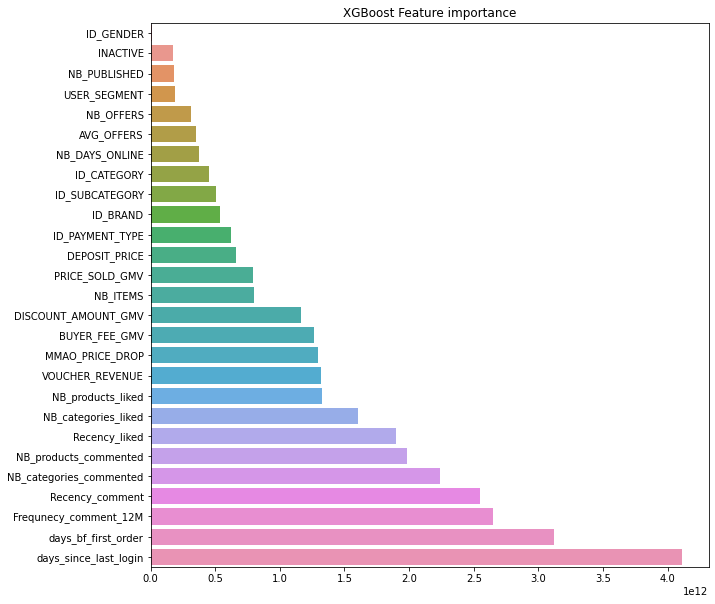

---------


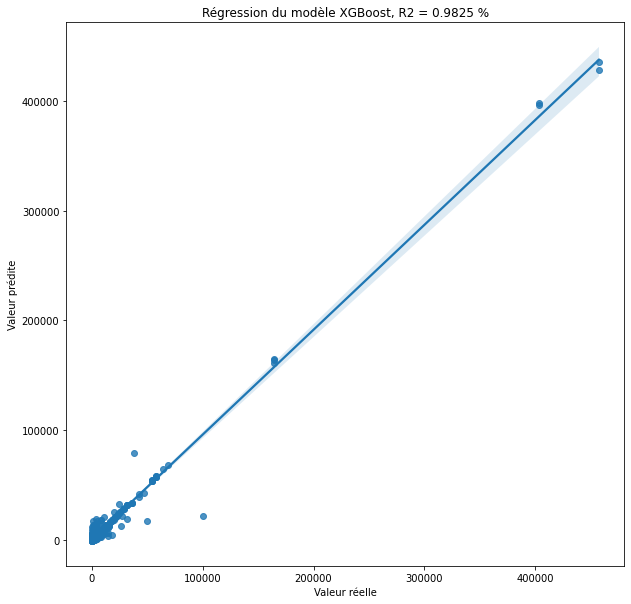

-------
Fin de l'évaluation du modèle XGBoost !


In [46]:
df_xgboost_tuned, model_test_xgb = xgb_evaluation(df, X_train_CLTV_scaled, X_test_CLTV_scaled, y_train_CLTV, y_test_CLTV)

In [25]:
# hyperparamter tuning for LightGBM
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test):
    '''
    Function that performs hyperparameter tuning on LightGBM model

    Parameters
    ----------
    X_train : pandas dataframe
        The train set

    X_test : pandas dataframe
        The test set

    y_train : pandas dataframe
        The train set

    y_test : pandas dataframe
        The test set

    Returns
    -------
    best_model : LightGBM model
        The best model after hyperparameter tuning

    '''

    #set a seed for reproducibility
    np.random.seed(42)

    # Create the parameter grid
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 1000),
        'num_leaves': Integer(10, 100),
        'max_depth': Integer(3, 10),
        'min_child_samples': Integer(10, 100),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(0.0, 0.5),
        'reg_lambda': Real(0.0, 0.5)
    }
        
    # Create the model to use for hyperparameter tuning
    model = LGBMRegressor(boosting_type='gbdt', n_jobs=-1, random_state=42)

    start= time.time()
    # Setup RandomizedSearchCV
    bayes_cv_tuner = BayesSearchCV(
        model,
        param_space,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    
    # Fit the RandomizedSearchCV version of model

    bayes_cv_tuner.fit(X_train, y_train)

    # Find the best model hyperparameters
    bayes_cv_tuner.best_params_

    end = time.time()

    print(f'Bayesian Search took {end - start} seconds')

    #print best score and params

    print('Best score: ', bayes_cv_tuner.best_score_)
    print('Best params: ', bayes_cv_tuner.best_params_)

    # Evaluate the RandomizedSearchCV model

    y_pred = bayes_cv_tuner.predict(X_test)

    # Evaluate the model

    print(f'MSE score: {mean_squared_error(y_test, y_pred)}')
    print(f'RMSE score: {np.sqrt(mean_squared_error(y_test, y_pred))}')
    print(f'MAE score: {mean_absolute_error(y_test, y_pred)}')
    print(f'R2 score: {r2_score(y_test, y_pred)}')


    # Create a dataframe with the feature importance

    feature_importance = pd.DataFrame({'Feature': colnames, 'Importance': bayes_cv_tuner.best_estimator_.feature_importances_})

    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Plot the feature importance

    plt.figure(figsize=(10, 10))

    sns.barplot(x=feature_importance['Importance'], y=feature_importance['Feature'])

    plt.title('Feature Importance')

    plt.show()


    # plot residual plot pour le modèle LightGBM

    plt.figure(figsize=(10, 10))
    sns.regplot(x=y_test, y=y_pred)
    plt.xlabel('Valeur réelle')
    plt.ylabel('Valeur prédite')
    plt.title(f'Régression du modèle LightGBM, R2 = {np.round(r2_score(y_test, y_pred),4)} %')
    plt.show()

    return bayes_cv_tuner.best_estimator_

Bayesian Search took 295.5731620788574 seconds
Best score:  -8490617.04185921
Best params:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.15155247944691969), ('max_depth', 10), ('min_child_samples', 10), ('n_estimators', 1000), ('num_leaves', 10), ('reg_alpha', 0.5), ('reg_lambda', 0.0), ('subsample', 0.9121342258738361)])
MSE score: 14134913.21919379
RMSE score: 3759.642698341664
MAE score: 697.8588014958486
R2 score: 0.9686385879542103


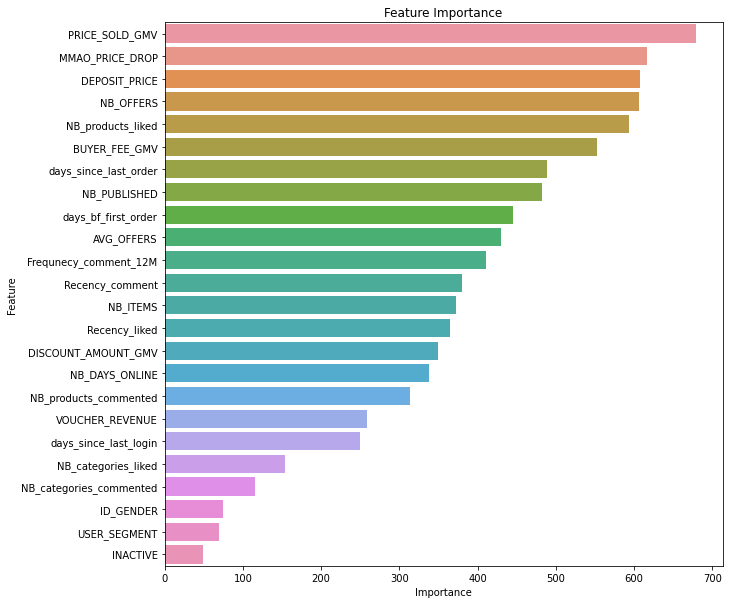

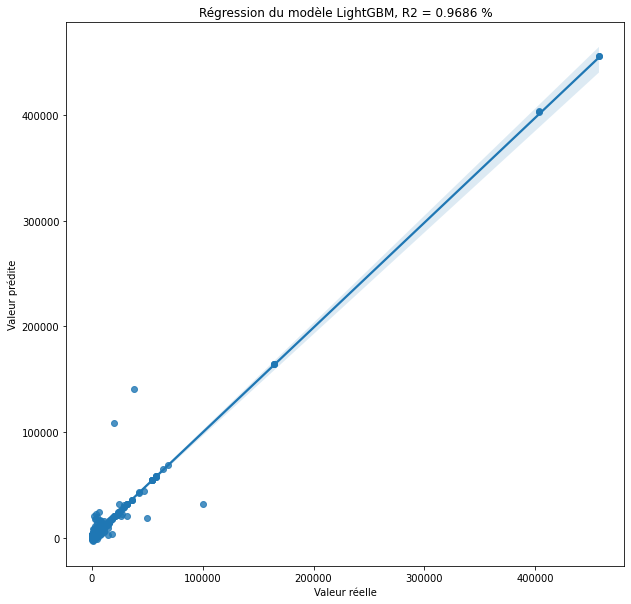

In [26]:
best_model_lgbm = hyperparameter_tuning_lgbm(X_train, X_test, y_train, y_test)

In [27]:
df.CLTV.describe()

count     10000.000000
mean       3339.095357
std       18596.370018
min          16.298021
25%         232.800457
50%         633.128988
75%        1877.019754
max      457269.017198
Name: CLTV, dtype: float64

## Implementation of our solution

Test with people who had only one purchase